# Importing necessary packages for analysis

In [3]:
import numpy as np
import pandas as pd
import os

from random import randint
from PIL import Image
import glob

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

#from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
# from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization,UpSampling2D,Concatenate

from tqdm import tqdm_notebook
import datetime

# Loading of training/testing ids and depths


In [4]:
# Defining the directories to find the data we will need (online directories). You can always change these to run locally with a different directory structure.
TRAIN_IMAGE_DIR = 'F:/7sem/tgs-salt-identification-challenge/train/images/'
TRAIN_MASK_DIR = 'F:/7sem/tgs-salt-identification-challenge/train/masks/'
TEST_IMAGE_DIR = 'F:/7sem/tgs-salt-identification-challenge/test/images/'
#MAIN_DIR = '../input/'

# Making a two-column data frame for the training data
train_df = pd.read_csv("F:/7sem/tgs-salt-identification-challenge/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("F:/7sem/tgs-salt-identification-challenge/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

# Listing the files in the specified directories
train_image_files = os.listdir(TRAIN_IMAGE_DIR)
train_mask_files = os.listdir(TRAIN_MASK_DIR)
test_image_files = os.listdir(TEST_IMAGE_DIR)

# Print the lists of files
print("Train Image Files:", train_image_files)
print("Train Mask Files:", train_mask_files)
print("Test Image Files:", test_image_files)

Train Image Files: ['000e218f21.png', '003c477d7c.png', '00441f1cf2.png', '0050766ae2.png', '005b452274.png', '0061281eea.png', '008a50a2ec.png', '00950d1627.png', '00a3af90ab.png', '00cda0328c.png', '0108518d1e.png', '010ee525b6.png', '0115703825.png', '01323211a0.png', '016fc8031c.png', '019afb4b4e.png', '01b5362cce.png', '01c033e116.png', '01c2045d03.png', '020376e68e.png', '020678ec1b.png', '02117a400e.png', '021494f3aa.png', '02206b234e.png', '022b1b01be.png', '023d486fba.png', '0243477802.png', '0249c49180.png', '026b509cd4.png', '026f97575b.png', '0280db420c.png', '0280deb8ae.png', '029c321179.png', '02adf272e9.png', '02d40993ab.png', '03049b14ca.png', '0304e9ac37.png', '03511989ac.png', '0389fc6012.png', '03a9a9f615.png', '03be56aa9a.png', '03c9b5ffe8.png', '03eed26d3e.png', '0401ae15d3.png', '04182ced8e.png', '041925f04c.png', '04234be388.png', '0429d9759b.png', '042c3d4e03.png', '04315b9a64.png', '044106f759.png', '045c5516a2.png', '0461a2fb30.png', '04711cb760.png', '0473e49

In [11]:
train_df.head() #Showing the first few rows of the training data IDs and depths (z).

,z
id,
575d24d81d,843
a266a2a9df,794
75efad62c1,468
34e51dba6a,727
4875705fb0,797


In [12]:
length_train = len(train_df)
print("The number of rows in the training dataframe is",length_train)

The number of rows in the training dataframe is 4000


In [13]:
test_df.head() 

,z
id,
353e010b7b,264
5439dbbddf,557
71bab9f311,846
52551f7a80,610
512d8d9997,577


In [14]:
length_test = len(test_df)
print("The number of rows in the test dataframe is",length_test)

The number of rows in the test dataframe is 18000


In [15]:
train_img_list = glob.glob(TRAIN_IMAGE_DIR+'*.png')
test_img_list = glob.glob(TEST_IMAGE_DIR+'*.png')
mask_img_list = glob.glob(TRAIN_IMAGE_DIR+'*.png')

train_img_sizes = [Image.open(f, 'r').size for f in train_img_list]
test_img_sizes = [Image.open(f, 'r').size for f in test_img_list]
mask_img_sizes = [Image.open(f, 'r').size for f in mask_img_list]

print("The minimum train image size is", min(train_img_sizes), "and the max is",max(train_img_sizes))
print("The minimum test image size is", min(test_img_sizes),"and the max is",max(test_img_sizes))
print("The minimum training mask image size is", min(mask_img_sizes),"and the max is",max(mask_img_sizes))

The minimum train image size is (101, 101) and the max is (101, 101)
The minimum test image size is (101, 101) and the max is (101, 101)
The minimum training mask image size is (101, 101) and the max is (101, 101)


In [16]:
print("The number of training images is",len(train_img_list))
print("The number of training masks is",len(mask_img_list))
print("The number of test images is",len(test_img_list))

The number of training images is 4000
The number of training masks is 4000
The number of test images is 18000


# Functions for upsampling and downsampling image sizes between 101x101 and 128x128 to work with U-Net convolutional neural network
It so happens that U-Net operates in bases of 2, and does not like pixel sizes of 101x101.

In [17]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

# When downsampling images, normally some kind of anti-aliasing should be used. 
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

# Showing the index range of train_df




In [18]:
print(train_df.index)

Index(['575d24d81d', 'a266a2a9df', '75efad62c1', '34e51dba6a', '4875705fb0',
       '782ae9b7e7', '9842f69f8d', 'aa94cfb806', '50d3073821', '28f865caaa',
       ...
       '633c7d5c80', '30082e87d9', 'f139be21a4', 'ac931ace49', 'cb36193e2f',
       '9cbd5ddba4', 'caa039b231', '1306fcee4c', '48d81e93d9', 'edf1e6ac00'],
      dtype='object', name='id', length=4000)


In [19]:
def filecount(dir_name):
    # return the number of files in directory dir_name
    try:
        return len([f for f in os.listdir(dir_name) if os.path.isfile(os.path.join(dir_name, f))])
    except Exception:
        return None
    

In [20]:
filecount(TRAIN_IMAGE_DIR) #Counting the files in the train image directory

4000

# Amplitude value of each pixel
Each pixel has its own color value or amplitude. The function 'load_img' is from 'keras.preprocessing.image,' and mentions the use of PIL. PIL interprets .PNG images to 256 intensities (or amplitude values) by default. Python's indices begin at 0, so the range would be 0 to 255. If we divide each pixel value by 255, we will normalize all pixel values to 1, where 0 represents completely white, and 1 represents completely black. From Pillow (PIL Fork) Documentation, Release 5.2.0:
"**PNG**
bits (experimental):  For P images, this option controls how many bits to store. If omitted, the PNG writer uses 8 bits (256 colors)."

### Adding 2 columns to the array train_df: "images" and "masks"
Adding the normalized pixel amplitude for each pixel in the image and in the mask.

In [21]:
from PIL import Image
import numpy as np

train_df["images"] = [np.array(Image.open(TRAIN_IMAGE_DIR + "{}.png".format(idx), 'r').convert("L")) / 255 for idx in train_df.index]

In [22]:
train_df["masks"] = [np.array(Image.open(TRAIN_IMAGE_DIR + "{}.png".format(idx), 'r').convert("L")) / 255 for idx in train_df.index]

## Notes on TQDM
TQDM is a way to track the progress of a loop. Directly from the repository README: "Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable), and you're done!"

In [23]:
train_df.head() # Showing the added columns normalized pixel values: "images" and "masks"

,z,images,masks
id,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.5254901960784314, 0.5137254901960784, 0.52..."
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.3411764705882353, 0.3764705882352941, 0.33..."
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.5686274509803921, 0.4666666666666667, 0.32..."
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.5411764705882353, 0.4745098039215686, 0.39..."
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.06666666666666667, 0.0784313725490196, 0.0..."


In [24]:
from scipy import signal

In [25]:
a_test = np.array([[3,2,4],[3,2,4],[3,2,4],[1,2,3]])
a_test.shape
b_test = [1,2,3]

c = signal.resample(b_test,2)
print(c)

[1. 3.]


# Calculating the salt coverage and salt coverage classes

Adding "coverage" column: Counting the number of salt pixels in the masks (all 0's or 1's) and dividing them by the image size (which is 101 pixels by 101 pixels in our case). It is useful to see what kind of distribution of coverage we have in our training (mask) data, as we should expect a similar amount of salt coverage in our predicted (mask) data.


In [26]:
train_df["coverage"] = train_df.masks.map(np.sum) / (img_size_ori*img_size_ori)

In [27]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

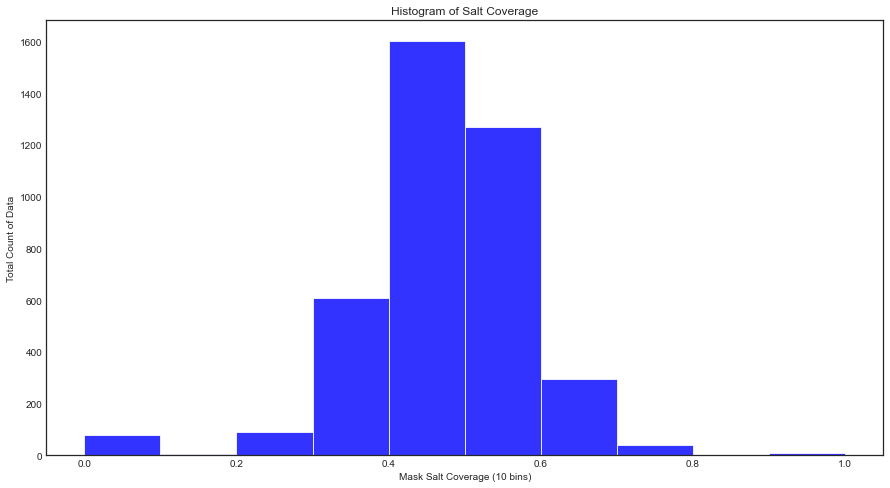

In [28]:
fig, ax = plt.subplots(figsize=(15,8))
num_bins = 10
n, bins, patches = plt.hist(train_df.coverage, num_bins, facecolor='blue', alpha=0.8)
ax.set_xlabel('Mask Salt Coverage (10 bins)')
ax.set_ylabel('Total Count of Data')
ax.set_title(r'Histogram of Salt Coverage')
plt.show()


In [29]:
train_df.head() 

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.5254901960784314, 0.5137254901960784, 0.52...",0.509362,6
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.3411764705882353, 0.3764705882352941, 0.33...",0.446499,5
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.5686274509803921, 0.4666666666666667, 0.32...",0.326398,4
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.5411764705882353, 0.4745098039215686, 0.39...",0.452548,5
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.06666666666666667, 0.0784313725490196, 0.0...",0.498696,5


In [30]:
train_df_dropzeros = train_df[~(train_df[['coverage']] == 0).any(axis=1)]

C:\Users\HOME\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HOME\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Depth distribution')

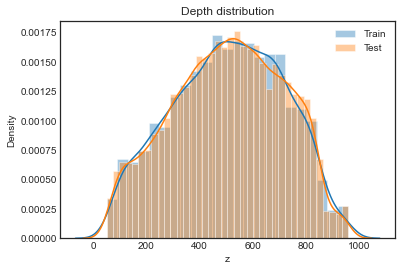

In [31]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

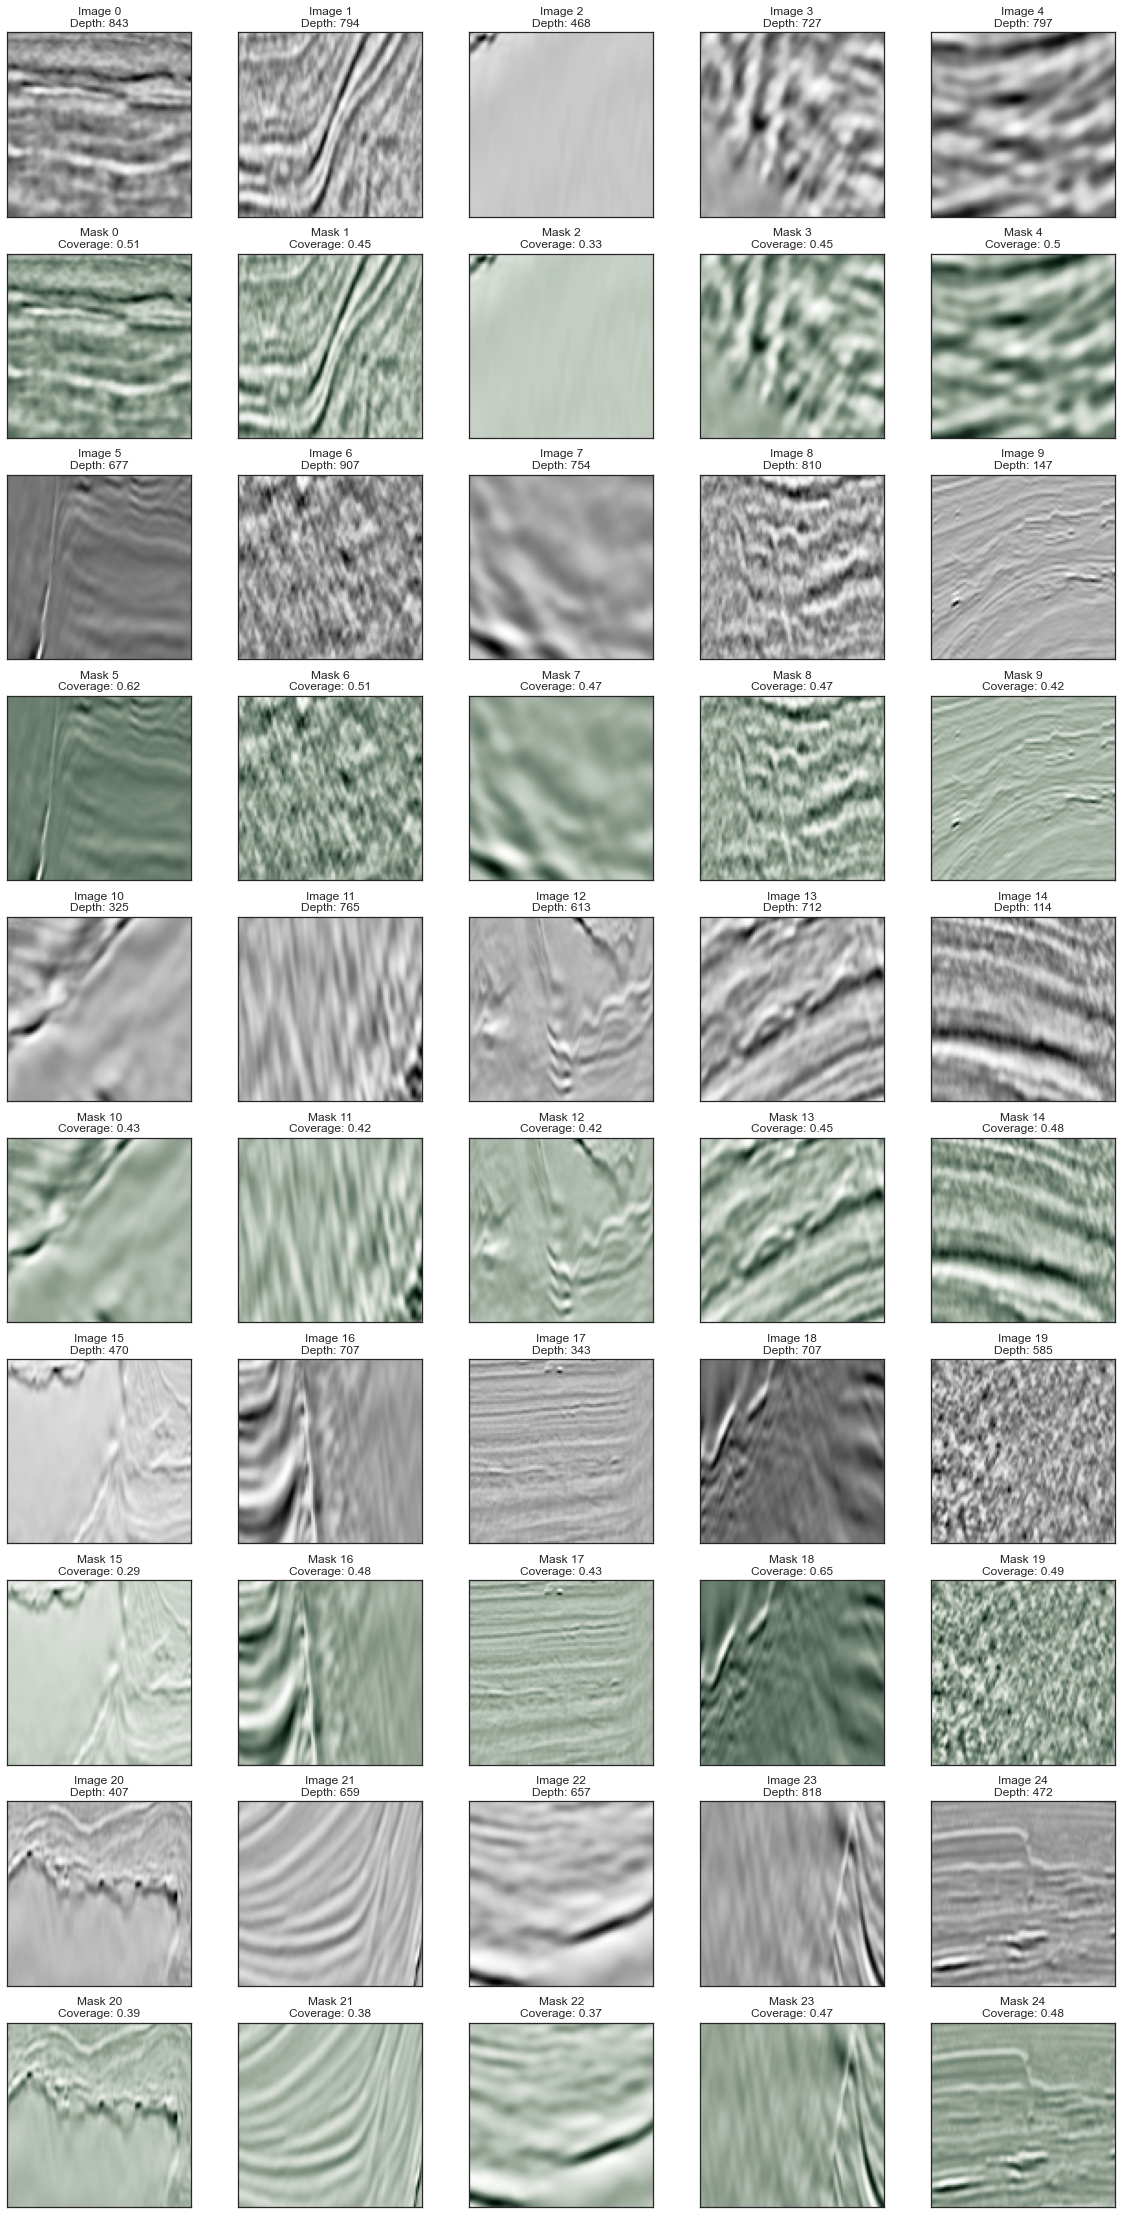

In [32]:
max_images = 25
grid_width = 5
grid_height = int(max_images / grid_width)*2
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax_image = axs[int(i / grid_width)*2, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image {0}\nDepth: {1}".format(i, train_df.loc[idx].z))
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*2+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.2, cmap="Greens")
    ax_mask.set_title("Mask {0}\nCoverage: {1}".format(i,  round(train_df.loc[idx].coverage, 2)))
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])

# Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [33]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

In [34]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    ucov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [35]:
def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = Dropout(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

In [36]:
#model = Model(input_layer, output_layer)
model = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True)

In [37]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d_19[0][0]']              
 alization)                     )                                                             

In [39]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

Text(0.5, 0.98, 'Top row: original images, bottom row: augmented images')

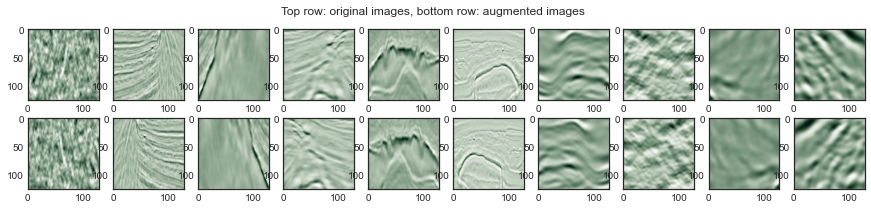

In [40]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

# Training

In [43]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000005, verbose=1)

epochs = 2
batch_size = 5

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/2
1280/1280 [==============================] - ETA: 0s - loss: 0.6454 - accuracy: 0.0203
Epoch 1: val_loss improved from inf to 0.63766, saving model to .\keras.model


INFO:tensorflow:Assets written to: .\keras.model\assets


INFO:tensorflow:Assets written to: .\keras.model\assets


1280/1280 [==============================] - 1260s 981ms/step - loss: 0.6454 - accuracy: 0.0203 - val_loss: 0.6377 - val_accuracy: 0.0212 - lr: 0.0010
Epoch 2/2
1280/1280 [==============================] - ETA: 0s - loss: 0.6441 - accuracy: 0.0203
Epoch 2: val_loss improved from 0.63766 to 0.63639, saving model to .\keras.model


INFO:tensorflow:Assets written to: .\keras.model\assets


INFO:tensorflow:Assets written to: .\keras.model\assets


1280/1280 [==============================] - 1368s 1s/step - loss: 0.6441 - accuracy: 0.0203 - val_loss: 0.6364 - val_accuracy: 0.0212 - lr: 0.0010


# Validation

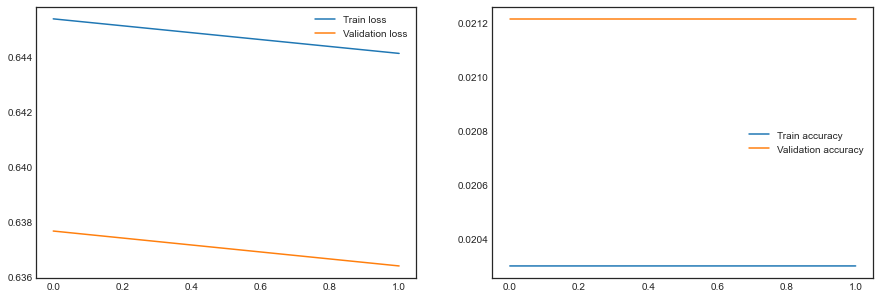

In [45]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_acc.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax_acc.legend()

# Predict the validation set to do a sanity check

In [46]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
mask_valid = np.array([downsample(x) for x in y_valid])

25/25 [==============================] - 25s 911ms/step


In [47]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [48]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(mask_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

C:\Users\HOME\AppData\Local\Temp\ipykernel_11992\1081568894.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  ious = np.array([iou_metric_batch(mask_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])


  0%|          | 0/50 [00:00<?, ?it/s]

In [49]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

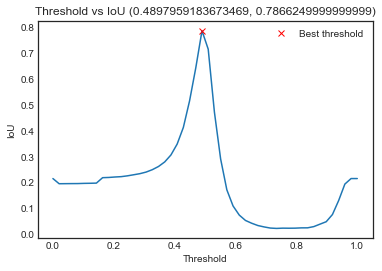

In [50]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

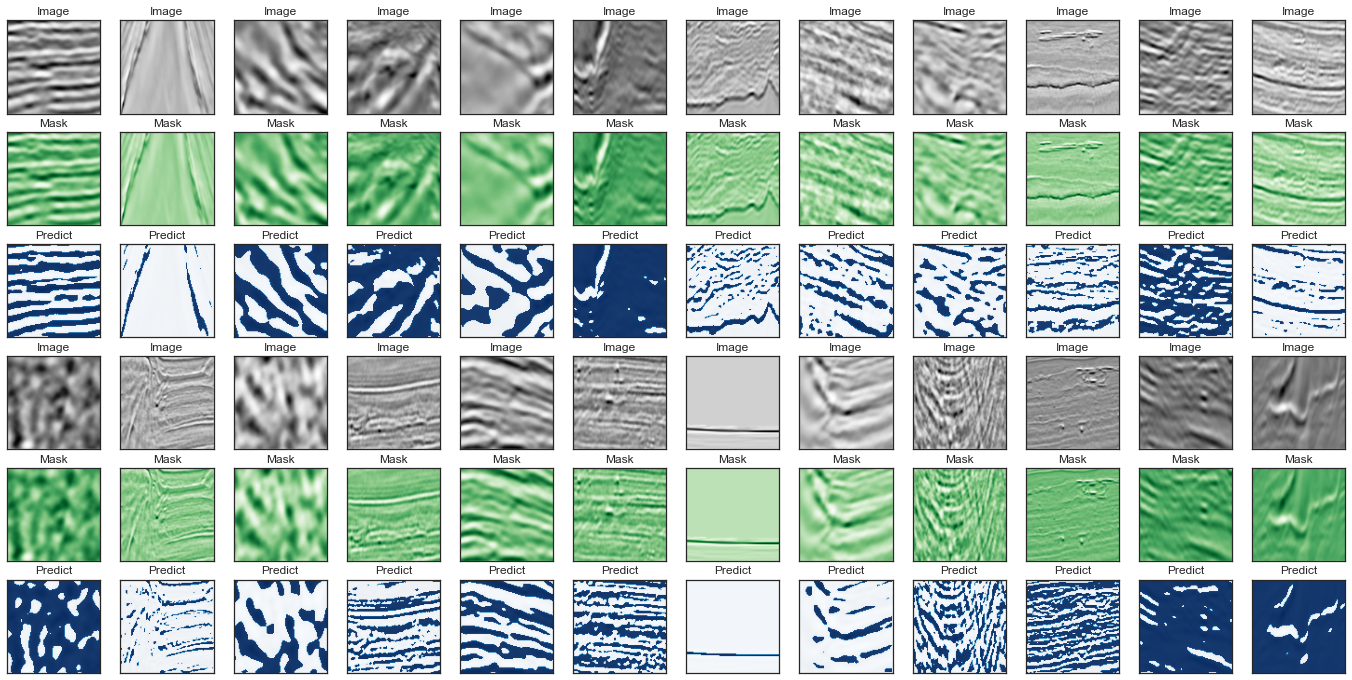

In [51]:
max_images = 24
grid_width = 12
grid_height = int(max_images / grid_width)*3
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*2, grid_height*2))
for i, idx in enumerate(ids_valid[:max_images]):
    img = downsample(np.squeeze(x_valid[i]))
    mask = np.squeeze(mask_valid[i])
    pred = np.squeeze(preds_valid[i]>threshold_best)
    ax_image = axs[int(i / grid_width)*3, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image")
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*3+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.9, cmap="Greens")
    ax_mask.set_title("Mask")
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])
    ax_pred = axs[int(i / grid_width)*3+2, i % grid_width]
    ax_pred.imshow(img, cmap="Greys")
    ax_pred.imshow(pred, alpha=0.9, cmap="Blues")
    coverage_pred = np.sum(pred) / pow(img_size_ori, 2)
    ax_pred.set_title("Predict")
    ax_pred.set_yticklabels([])
    ax_pred.set_xticklabels([])

In [52]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []
    r = 0
    pos = 1
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [57]:
x_test = np.array([upsample(np.array(Image.open(TEST_IMAGE_DIR + "{}.png".format(idx), 'r').convert("L"))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

C:\Users\HOME\AppData\Local\Temp\ipykernel_11992\2979117593.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  x_test = np.array([upsample(np.array(Image.open(TEST_IMAGE_DIR + "{}.png".format(idx), 'r').convert("L"))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)


  0%|          | 0/18000 [00:00<?, ?it/s]

In [58]:
preds_test = model.predict(x_test)

563/563 [==============================] - 581s 1s/step


In [59]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

C:\Users\HOME\AppData\Local\Temp\ipykernel_11992\2944914293.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}


  0%|          | 0/18000 [00:03<?, ?it/s]

In [60]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
print('Submission output to: sub-{}.csv'.format(timestamp))
sub.to_csv("sub-{}.csv".format(timestamp))

Submission output to: sub-20231120-2140.csv
